In [30]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import KElbowVisualizer #kmeans

In [3]:
customers = pd.read_csv('../CSV-Excels/P5_datasets/olist_customers_dataset.csv')
item_orders = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_items_dataset.csv')
order_payments = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../CSV-Excels/P5_datasets/olist_orders_dataset.csv')

In [67]:
# Dates des commandes du premier et dernier client du jeu de données
# print(orders_date_with_customer_id['order_purchase_timestamp'].min())
# print(orders_date_with_customer_id['order_purchase_timestamp'].max())

2016-09-04 21:15:19
2018-10-17 17:30:18


In [68]:
def create_final_df(customers, orders, item_orders, order_reviews, payments, scaler, date):
    customer_ids = customers[["customer_id", "customer_unique_id"]]
    orders_date_with_customer_id = orders[["customer_id", "order_id", "order_purchase_timestamp"]]
    orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
    orders_date_with_customer_id = orders_date_with_customer_id.merge(how='left', on='customer_id', right=customer_ids)
    orders_limited_date = orders_date_with_customer_id[orders_date_with_customer_id['order_purchase_timestamp'] <= date]
    orders_limited_date['days_since_last_purchase'] = (
    orders_limited_date['order_purchase_timestamp'].max() - orders_limited_date['order_purchase_timestamp']
    ).dt.days
    orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
    lambda x: 1 if ((x.strftime("%m/%d") > "11/01") & (x.strftime("%m/%d") < "12/25")) else 0)
    nb_items_bought = item_orders[["order_id", "order_item_id"]]
    nb_items_bought.drop_duplicates(subset=['order_id'], keep='last', inplace=True, ignore_index=True)
    df = orders_limited_date.merge(how='left', on='order_id', right=nb_items_bought)
    order_score = order_reviews[["order_id", "review_score"]]
    df = df.merge(how='left', on='order_id', right=order_score)
    payments = order_payments[["order_id", "payment_installments", "payment_value"]]
    df = df.merge(how='left', on='order_id', right=payments)
    number_of_purchase = df.groupby('customer_unique_id').size()
    data = df.groupby('customer_unique_id').mean()
    data['number_of_purchase'] = number_of_purchase
    data.rename(columns={'order_item_id':'number_of_products_bought'}, inplace=True)
    data = data[data['payment_installments'] > 0]
    data = data[(~data['payment_value'].isna()) & (data['payment_value'] != 0)]
    data.fillna(data.mean(), inplace=True)
    data["payment_installments"] = np.log10(data['payment_installments'].values)
    data["payment_value"] = np.log10(data['payment_value'].values)
    data_scaled = pd.DataFrame(scaler.fit_transform(data),
                        columns=data.columns)
    return data_scaled

In [461]:
# Données min max scalées

# 06-2107 au bout de 5 mois ari = 0.25        => chute des performances dès 11-2017
# 09-2017 au bout de 9 semaines ari = 0.41       car la variable christmas purchase
# 01-2018 ari = 0.99 tout le temps               prend son sens à cette période
ari_scores = [1]  
ari_scores_initial_scaler = [1]
dates = []
date = pd.Timestamp('2017-06-01')
dates.append(date)
max_date = orders_date_with_customer_id['order_purchase_timestamp'].max()
mm_scaler_0 = MinMaxScaler()
d0 = create_final_df(customers, orders, item_orders, order_reviews, payments, mm_scaler_0, date)
km1 = KMeans(n_clusters=3, n_init='auto')
km1.fit(d0)
while date < max_date:
    date += pd.Timedelta('7 days')
    dates.append(date)
    # créer dn avec un nouveau scaler
    mm_scaler_n = MinMaxScaler()
    dn = create_final_df(customers, orders, item_orders, order_reviews, payments, mm_scaler_n, date)

    # créer un dn scalé avec le scaler initial
    dn_initial_scaler = create_final_df(customers, orders, item_orders, order_reviews, payments, mm_scaler_0, date)
    r1_initial_scaler = km1.predict(dn_initial_scaler)
    km2 = KMeans(n_clusters=3)
    r2 = km2.fit_predict(dn)
    ari = adjusted_rand_score(r2, r1_initial_scaler)
    ari_scores.append(ari)

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

/tmp/ipykernel_32865/2437103429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_32865/2437103429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_32865/2437103429.py:7: SettingWithCop

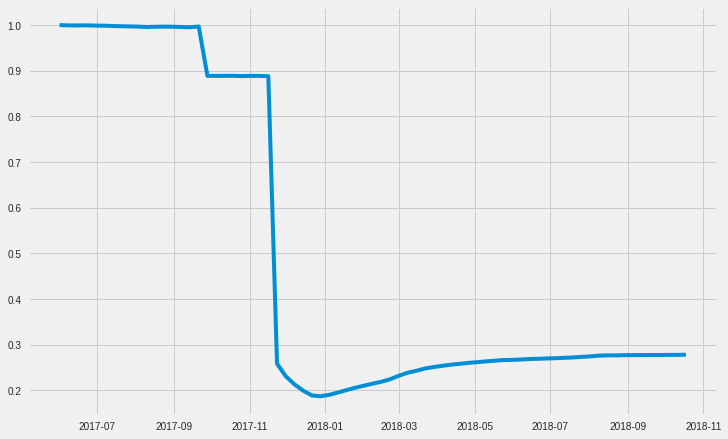

In [455]:
# Depuis 06-2017
plt.figure(figsize=(11,5))
plt.plot(dates, ari_scores)
plt.show()

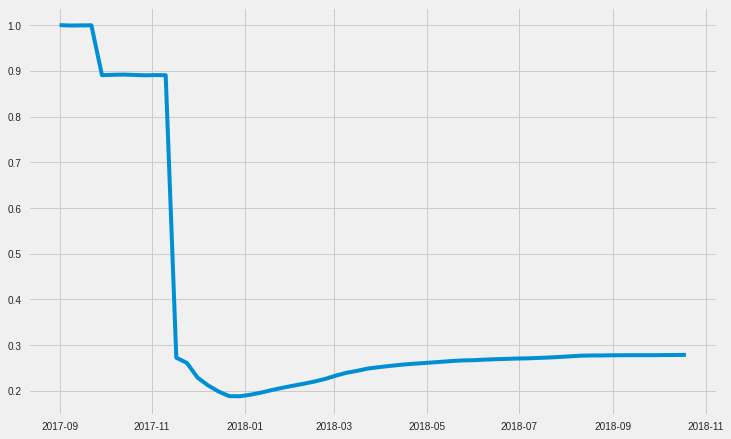

In [452]:
# Depuis 09-2017
plt.figure(figsize=(11,7))
plt.plot(dates, ari_scores)
plt.show()

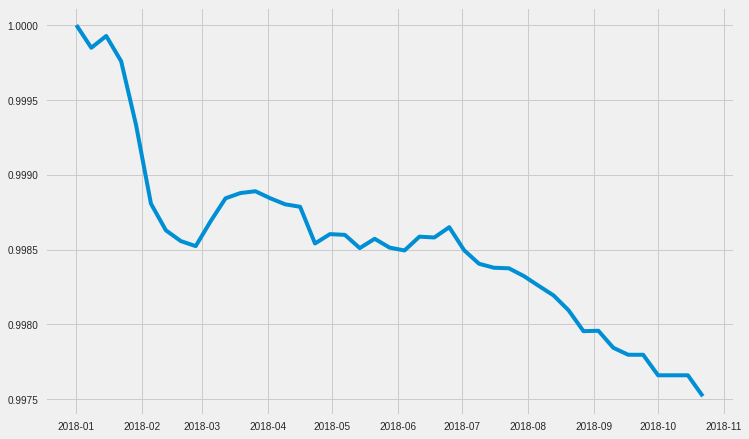

In [459]:
# Depuis 01-2018
plt.figure(figsize=(11,7))
plt.plot(dates, ari_scores)
plt.show()

In [462]:
ari_scores

[1,
 0.9994247409471403,
 0.9992475999078172,
 0.999527600701684,
 0.9990593733742495,
 0.998963316191574,
 0.9981213407556038,
 0.9977597451361224,
 0.9971870887133925,
 0.9973212973715608,
 0.9958173153800672,
 0.9963837585138464,
 0.9966828501375653,
 0.9966226406265585,
 0.9952109895242442,
 0.9952840482623336,
 0.9955051810809579,
 0.8888967592730194,
 0.8886932236798196,
 0.8888200916771659,
 0.8890233319295344,
 0.8883697100293173,
 0.8887365208888303,
 0.888705862117003,
 0.27486714231933035,
 0.25867590161321125,
 0.23082197140938238,
 0.21313435294942595,
 0.199281668031705,
 0.18878209661780398,
 0.1869776355803112,
 0.19007452884317505,
 0.19514789343617703,
 0.20055956113906742,
 0.2057038653372846,
 0.21014091480421945,
 0.2145768415308059,
 0.21875291970222585,
 0.22423878186247273,
 0.23184288774256637,
 0.238460645316806,
 0.24267343350695447,
 0.24776376932071129,
 0.25093083748333034,
 0.2536797287642782,
 0.2560735917673689,
 0.25808390251129987,
 0.2600485034684733

In [113]:
def create_final_df(customers, orders, item_orders, order_reviews, payments, scaler, date):
    customer_ids = customers[["customer_id", "customer_unique_id"]]
    orders_date_with_customer_id = orders[["customer_id", "order_id", "order_purchase_timestamp"]]
    orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
    orders_date_with_customer_id = orders_date_with_customer_id.merge(how='left', on='customer_id', right=customer_ids)
    orders_limited_date = orders_date_with_customer_id[orders_date_with_customer_id['order_purchase_timestamp'] <= date]
    orders_limited_date['days_since_last_purchase'] = (
    orders_limited_date['order_purchase_timestamp'].max() - orders_limited_date['order_purchase_timestamp']
    ).dt.days
    orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
    lambda x: 1 if ((x.strftime("%m/%d") > "11/01") & (x.strftime("%m/%d") < "12/25")) else 0)
    nb_items_bought = item_orders[["order_id", "order_item_id"]]
    nb_items_bought.drop_duplicates(subset=['order_id'], keep='last', inplace=True, ignore_index=True)
    df = orders_limited_date.merge(how='left', on='order_id', right=nb_items_bought)
    order_score = order_reviews[["order_id", "review_score"]]
    df = df.merge(how='left', on='order_id', right=order_score)
    payments = order_payments[["order_id", "payment_installments", "payment_value"]]
    df = df.merge(how='left', on='order_id', right=payments)
    number_of_purchase = df.groupby('customer_unique_id').size()
    data = df.groupby('customer_unique_id').mean()
    data['number_of_purchase'] = number_of_purchase
    data.rename(columns={'order_item_id':'number_of_products_bought'}, inplace=True)
    data = data[data['payment_installments'] > 0]
    data = data[(~data['payment_value'].isna()) & (data['payment_value'] != 0)]
    data.fillna(data.mean(), inplace=True)
    mms = MinMaxScaler()
    data["payment_installments"] = np.log10(data['payment_installments'].values)
    data["payment_value"] = np.log10(data['payment_value'].values)
#     data_scaled = pd.DataFrame(scaler.fit_transform(data),
#                         columns=data.columns)
    data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(columns=["days_since_last_purchase"])),
                        columns=data.drop(columns=["days_since_last_purchase"]).columns)
    data_scaled[["days_since_last_purchase"]] = mms.fit_transform(data[["days_since_last_purchase"]])

    return data_scaled

In [109]:
 # 01-2018 ari = 0.46 AU BOUT DE 6 SEMAINES, SANS N INIT
#     0.90 si je mms days since last purchase, sans init avec k = 5
#     0.88 si je mms days since last purchase, sans init avec k = 6
ari_scores = [1]  
ari_scores_initial_scaler = [1]
dates = []
date = pd.Timestamp('2017-06-01')
dates.append(date)
max_date = orders_date_with_customer_id['order_purchase_timestamp'].max()
# init scaler
std_scaler_0 = StandardScaler()
d0 = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_0, date)
km1 = KMeans(n_clusters=6)
km1.fit(d0)
while date < max_date:
    date += pd.Timedelta('7 days')
    dates.append(date)
    # créer dn avec un nouveau scaler
    std_scaler_n = StandardScaler()
    dn = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_n, date)

    # créer un dn scalé avec le scaler initial
    dn_initial_scaler = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_0, date)
    r1_initial_scaler = km1.predict(dn_initial_scaler)
    km2 = KMeans(n_clusters=6)
    r2 = km2.fit_predict(dn)
    
    ari = adjusted_rand_score(r2, r1_initial_scaler)
    ari_scores.append(ari)

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_dat

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

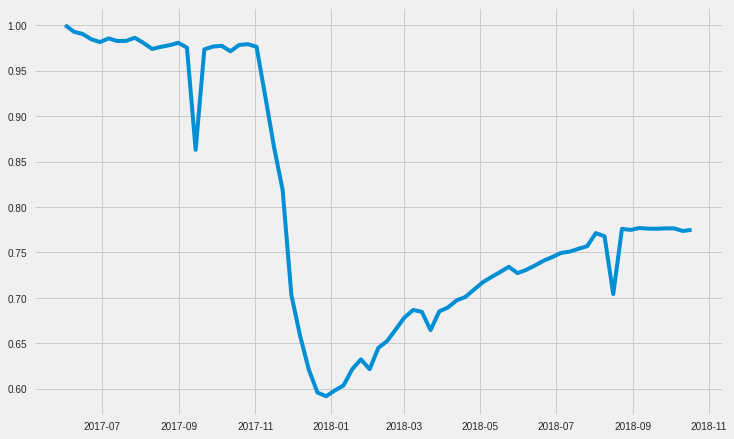

In [110]:
# Depuis 06-2017
plt.figure(figsize=(11,7))
plt.plot(dates, ari_scores)
plt.show()

In [116]:
#  0.90 si je mms days since last purchase, sans init avec k = 5
#  0.88 si je mms days since last purchase, sans init avec k = 6

ari_scores = [1]  
ari_scores_initial_scaler = [1]
dates = []
date = pd.Timestamp('2018-01-01')
dates.append(date)
max_date = orders_date_with_customer_id['order_purchase_timestamp'].max()
# init scaler
std_scaler_0 = StandardScaler()
d0 = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_0, date)
km1 = KMeans(n_clusters=6)
km1.fit(d0)
while date < max_date:
    date += pd.Timedelta('7 days')
    dates.append(date)
    # créer dn avec un nouveau scaler
    std_scaler_n = StandardScaler()
    dn = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_n, date)

    # créer un dn scalé avec le scaler initial
    dn_initial_scaler = create_final_df(customers, orders, item_orders, order_reviews, payments, std_scaler_0, date)
    r1_initial_scaler = km1.predict(dn_initial_scaler)
    km2 = KMeans(n_clusters=6)
    r2 = km2.fit_predict(dn)
    
    ari = adjusted_rand_score(r2, r1_initial_scaler)
    ari_scores.append(ari)

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

/tmp/ipykernel_58641/867870090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
/tmp/ipykernel_58641/867870090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_limited_date['days_since_last_purchase'] = (
/tmp/ipykernel_58641/867870090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

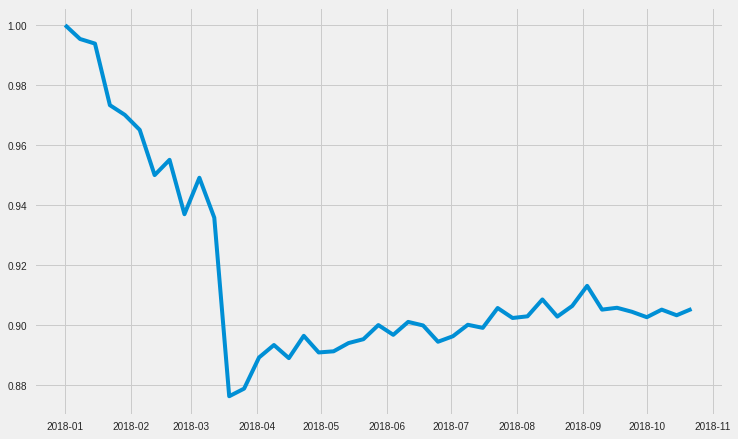

In [117]:
# Depuis 01-2018
plt.figure(figsize=(11,7))
plt.plot(dates, ari_scores)
plt.show()